In [1]:
import argparse
from torch.autograd import Function
import math
import os
import pandas as pd
import numpy as np 
from scipy.special import softmax
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

# from loaders.ultrasound_dataset import USDataset
from torch.utils.data import DataLoader

from loaders.ultrasound_dataset_classification import USDataset
from transforms.ultrasound_transforms import USClassEvalTransforms
from transferModel import EfficientNetTransfer
# from transforms.ultrasound_transforms import USEvalTransforms

from sklearn.utils import class_weight
from sklearn.metrics import classification_report

from tqdm import tqdm

import pickle

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

from captum.attr import GuidedGradCam, GuidedBackprop, LayerGradCam
import matplotlib.pyplot as plt
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from torchvision import transforms
from monai.transforms import ScaleIntensityRange

from pl_bolts.transforms.dataset_normalizations import (
    imagenet_normalization
)
import nrrd
from PIL import Image

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import torchvision.transforms as T
from PIL import Image
import cv2
# from matplotlib.backends.backend_qt4agg import FigureCanvasQTAgg as FigureCanvas

import pydicom
from sklearn.model_selection import train_test_split
import uuid
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning proje

In [2]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import numpy as np
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F


In [4]:
# just get efficientnet bo... I dont know why exactly. i deally would be the prefectly trained model

list_image_paths = [
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/ac5316ee-2731-4ab1-b40f-2911f4a79939/0809e0ac-1a38-4076-b09f-28a09e7b69eb/95.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/26007059-020e-479d-b1fa-93f1254fd994/ba27a10a-db47-461d-a56a-c57d63050c6b/11.nrrd ',
    # '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/8597b708-3c45-45e8-9d8d-1861c2dd7698/6ad3d093-8072-4a36-b0b4-5a1648df228c/123.nrrd ',
    # '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/d93fa256-fba3-4e52-a89d-6011818e97e9/4f06c84a-9e9c-4426-87b2-efb080befdef/72.nrrd ',
    # '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/5e4edcd3-0881-4717-a12c-db9821984ba2/e364204a-b9a4-4651-9909-38eb29e96608/58.nrrd ',
    # '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/c305ead9-fecc-4ed8-b136-0811ca1a25be/ed8c291c-0ac5-4f7a-8e7b-131b0d655691/195.nrrd ',
    # '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/a1e29ffa-f189-4020-9320-eb95b3f4f882/355cef54-5955-4d71-a656-1720a0769829/49.nrrd ',
    # '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/04d16a0c-d34c-4021-9bd7-24d28d71f80e/2588b404-19b3-4c48-bdb4-7d3ade3fcbd3/128.nrrd ',
    # '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/3d4228c8-3d68-4d48-a17e-aa1990f5b5e7/c8855619-9ee8-4354-b3d2-c99d167884db/191.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/101.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/42.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/10.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/72.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/185.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/98.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/108.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/99.nrrd ',
    '//mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/125.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/89.nrrd ',
    # '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/b0ad5037-ffc1-426b-9001-08a50b901cdc/76428c9e-1e81-4d21-8095-2c64fd49df21/66.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/36.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/67.nrrd ',
    '/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/107.nrrd ',
]
# !ls /mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/f9025f72-b033-4956-a1cb-b916e3041d98/a81f7208-ea76-4947-a869-7cb52cf8d990/

In [5]:
!ls /mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/ac5316ee-2731-4ab1-b40f-2911f4a79939/0809e0ac-1a38-4076-b09f-28a09e7b69eb/95.nrrd 

/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/ac5316ee-2731-4ab1-b40f-2911f4a79939/0809e0ac-1a38-4076-b09f-28a09e7b69eb/95.nrrd


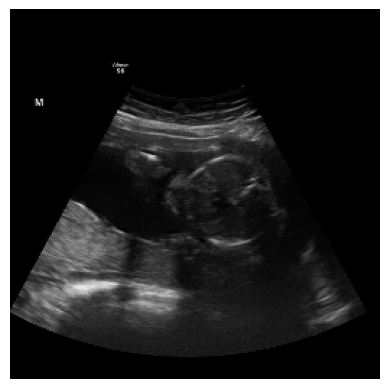

In [6]:
def myshow(img_path):
    img = sitk.ReadImage(img_path)
    nda = sitk.GetArrayFromImage(img)
    plt.imshow(nda, cmap='gray')
    plt.axis('off')
    plt.show()
image_path = "/mnt/raid/C1_ML_Analysis/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/ac5316ee-2731-4ab1-b40f-2911f4a79939/0809e0ac-1a38-4076-b09f-28a09e7b69eb/95.nrrd"
#217

myshow(image_path)

In [7]:
# Step 1: Instantiate the EfficientNet model
model = models.efficientnet_b0(pretrained=True)
model.eval()
torch.set_grad_enabled(True)

img = sitk.ReadImage(image_path)
nda = np.array(sitk.GetArrayFromImage(img))

# Step 2: Enable Gradient Computation
input_image_1 = transforms.ToTensor()(nda).unsqueeze(0)
input_image = input_image_1.expand(-1,3, -1, -1)
# input_image = torch.stack([input_image_1] * 3, dim=0)
# input_image= (input_image).unsqueeze(0)
# input_image.re
input_image.requires_grad = True



/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# # Define a function to print names and types of model children
# def print_model_children(model, parent_name=''):
#     for name, child in model.named_children():
#         full_name = f'{parent_name}.{name}' if parent_name else name
#         # print(f'Layer Name: {full_name}, Layer Type: {type(child)}')

#         if isinstance(child, torch.nn.Module):
#             print_model_children(child, parent_name=full_name)
#         else:
#             print(f'Layer Name: {full_name}, Layer:{child}')


# # Print names and types of model children
# print_model_children(model)

In [9]:
# # Print the model architecture to inspect the layers
# # print(model)

# # Define a function to get all convolutional layers in the model
# def get_conv_layers(model):
#     conv_layers = []
#     for name, layer in model.named_children():
#         if isinstance(layer, nn.Conv2d):
#             conv_layers.append((name, layer))
#         elif isinstance(layer, nn.Sequential):
#             # Recursively check for conv layers in nested Sequentials
#             nested_conv_layers = get_conv_layers(layer)
#             if nested_conv_layers:
#                 conv_layers.extend([(f'{name}.{sub_name}', sub_layer) for sub_name, sub_layer in nested_conv_layers])
#     return conv_layers

# # Get all convolutional layers in the EfficientNet model
# all_conv_layers = get_conv_layers(model)

# # Print the names of the convolutional layers
# for name, _ in all_conv_layers:
#     print(name)

In [10]:
feature_maps = {}

def get_feature_maps(module,input,output):
    feature_maps[module] = output.detach()

gradients = {}

def get_gradients(module,grad_input,grad_output):
    gradients[module] = grad_output[0].detach()

for name,target_layer in layers_of_interest:
    target_layer.register_forward_hook(get_feature_maps)
    target_layer.register_backward_hook(get_gradients)


NameError: name 'layers_of_interest' is not defined

In [ ]:
# Step 3: Perform Forward Pass
output = model(input_image)
target_class = 0  # Replace with the target class index

model.zero_grad()
output[0, target_class].backward()




In [11]:
# Define a list to store all layers
all_layers = []

# Define a function to print names and types of model children
def print_and_store_layers(model, layers, parent_name=''):
    for name, child in model.named_children():
        full_name = f'{parent_name}.{name}' if parent_name else name
        layers.append((full_name, child))
        # print(f'Layer Name: {full_name}, Layer Type: {type(child)}')
        if isinstance(child, torch.nn.Module):
            print_and_store_layers(child, layers, parent_name=full_name)

# Print names and types of model children and store them in the all_layers list
print_and_store_layers(model, all_layers)

# Now, you can inspect the all_layers list and select the layers you're interested in
for i in range(len(all_layers)):
    print(i,".",all_layers[i][0])

0 . features
1 . features.0
2 . features.0.0
3 . features.0.1
4 . features.0.2
5 . features.1
6 . features.1.0
7 . features.1.0.block
8 . features.1.0.block.0
9 . features.1.0.block.0.0
10 . features.1.0.block.0.1
11 . features.1.0.block.0.2
12 . features.1.0.block.1
13 . features.1.0.block.1.avgpool
14 . features.1.0.block.1.fc1
15 . features.1.0.block.1.fc2
16 . features.1.0.block.1.activation
17 . features.1.0.block.1.scale_activation
18 . features.1.0.block.2
19 . features.1.0.block.2.0
20 . features.1.0.block.2.1
21 . features.1.0.stochastic_depth
22 . features.2
23 . features.2.0
24 . features.2.0.block
25 . features.2.0.block.0
26 . features.2.0.block.0.0
27 . features.2.0.block.0.1
28 . features.2.0.block.0.2
29 . features.2.0.block.1
30 . features.2.0.block.1.0
31 . features.2.0.block.1.1
32 . features.2.0.block.1.2
33 . features.2.0.block.2
34 . features.2.0.block.2.avgpool
35 . features.2.0.block.2.fc1
36 . features.2.0.block.2.fc2
37 . features.2.0.block.2.activation
38 . f

In [12]:
# layers_of_interest = all_conv_layers

# block.0
layers_of_interest = [all_layers[9],all_layers[26],
                      all_layers[46],all_layers[67],
                      all_layers[87],all_layers[108],
                      all_layers[128],all_layers[148],
                      all_layers[169],all_layers[208],
                      ]

# # .fc1
# layers_of_interest = [all_layers[14],all_layers[35],
#                       all_layers[55],all_layers[76],
#                       all_layers[96],all_layers[117],
#                       all_layers[198],all_layers[239],
#                       all_layers[259],all_layers[320],
#                       ]

In [13]:
feature_maps = {}

def get_feature_maps(module,input,output):
    feature_maps[module] = output.detach()

gradients = {}

def get_gradients(module,grad_input,grad_output):
    gradients[module] = grad_output[0].detach()

for name,target_layer in layers_of_interest:
    target_layer.register_forward_hook(get_feature_maps)
    target_layer.register_backward_hook(get_gradients)


In [14]:
# Step 3: Perform Forward Pass
output = model(input_image)
target_class = 0  # Replace with the target class index

model.zero_grad()
output[0, target_class].backward()




/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [15]:
# for k,_ in enumerate(layers_of_interest):
#     my_feature_map = gradients[layers_of_interest[k][1]]
#     n = my_feature_map.shape[1]
#     plt.figure(figsize=(12*5,4*5))
#     for i in range(n):
#         plt.subplot(1,n,i+1)
#         # print(my_feature_map[0,i])
#         plt.imshow(my_feature_map[0,i].cpu().numpy(), cmap = "gray")
#         plt.axis("off")
#     plt.show()


In [16]:
# for k,_ in enumerate(layers_of_interest):
#     my_feature_map = feature_maps[layers_of_interest[k][1]]
#     n = my_feature_map.shape[1]
#     plt.figure(figsize=(12*5,4*5))
#     for i in range(n):
#         plt.subplot(1,n,i+1)
#         # print(my_feature_map[0,i])
#         plt.imshow(my_feature_map[0,i].cpu().numpy(), cmap = "gray")
#         plt.axis("off")
#     plt.show()


In [17]:
input_image.shape

torch.Size([1, 3, 256, 256])

In [18]:
# weighted_maps = feature_maps*gradients
# have to iterate over as they are dicts

cams = {}

for layer in feature_maps:
    if layer in gradients:
        weighted_maps  =feature_maps[layer] * gradients[layer]
        # print(" shape: ",feature_maps[layer].shape , gradients[layer].shape, weighted_maps.shape )
        cam = F.relu(weighted_maps.sum(dim= 1, keepdim=True))
        cam_normalise = cam/ (torch.max(cam) + 1e-5)
        resized_cam = F.interpolate(cam_normalise, size= (input_image.shape[2],input_image.shape[3]), mode = "bilinear", align_corners= False)
        cams[layer] = resized_cam 
    else:
        print("error ")
        print(gradients[layer])
# 

In [19]:
cam_stack = torch.stack(tuple(cams.values()))
fused_cam = torch.mean(cam_stack, dim=0)

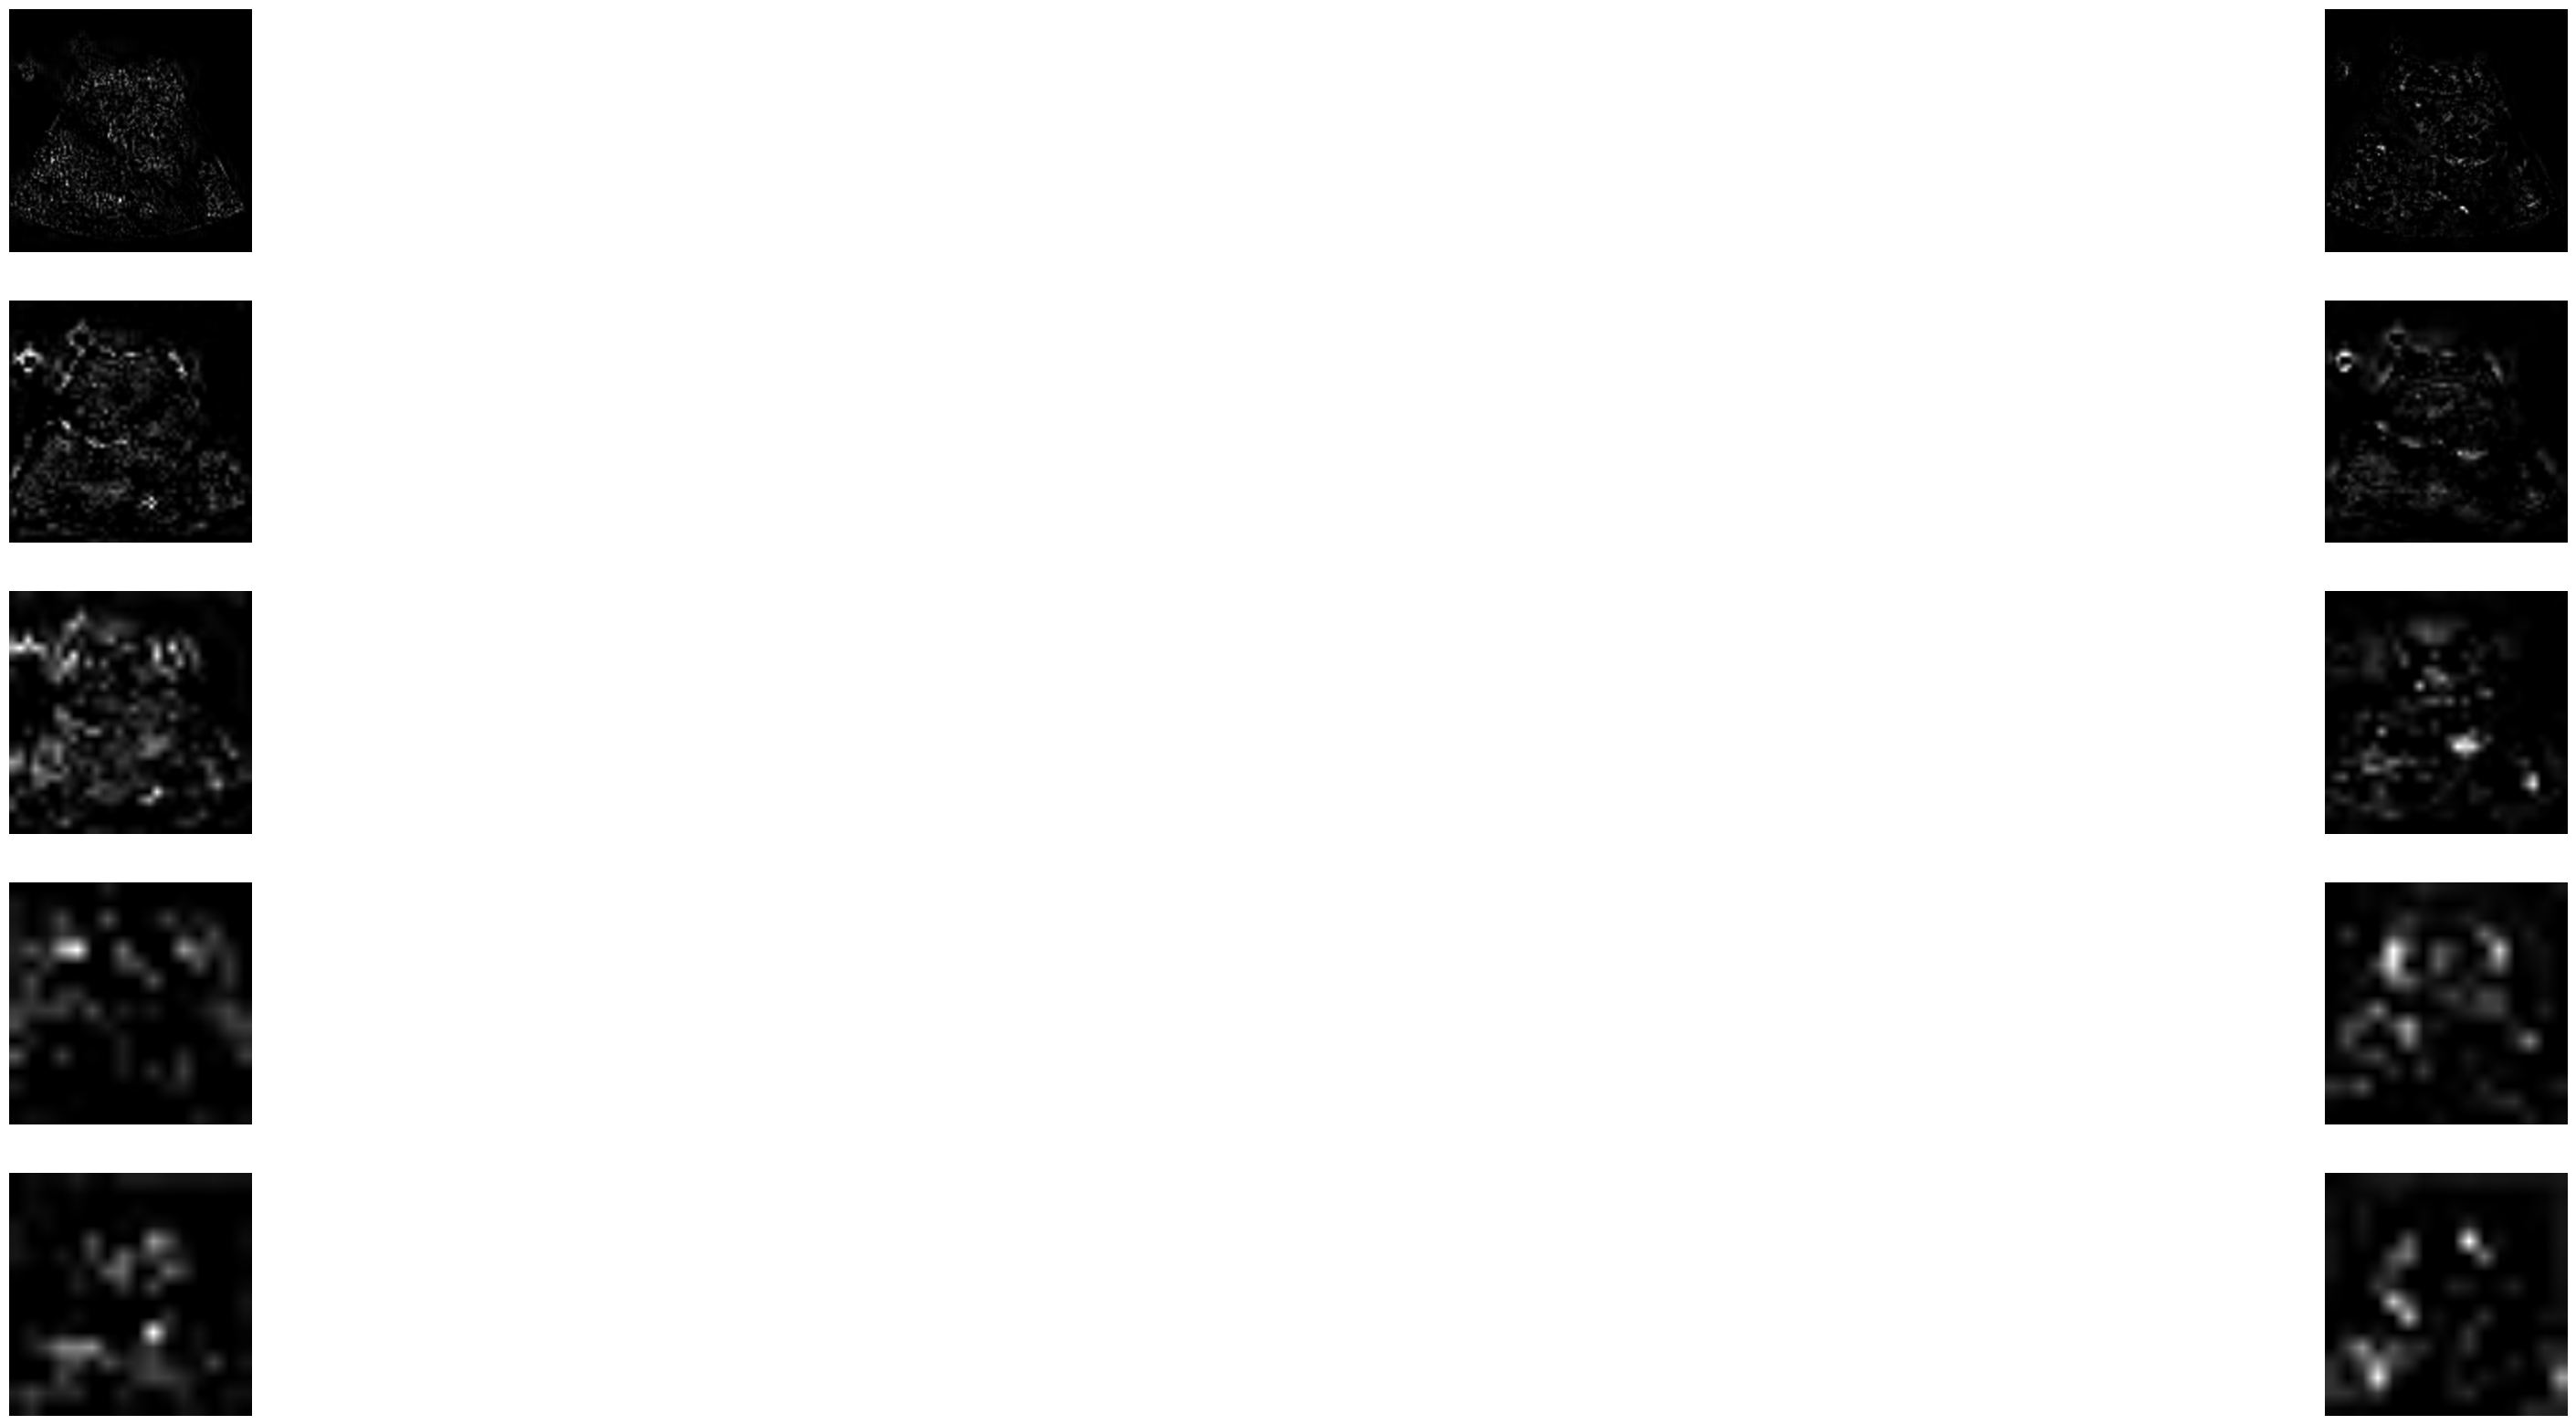

In [22]:
n = cam_stack.shape[0]
nrows = int(5)
ncols = int(np.ceil(n/nrows))
fig, ax = plt.subplots(figsize=(12*5,4*5), nrows=nrows, ncols=ncols)
for i,cam_i in enumerate(cam_stack):
    cam = cam_i.squeeze()
    # print(nrows, ncols,i)
    plt.subplot(nrows, ncols,i+1)
    # print(my_feature_map[0,i])
    plt.imshow(cam.cpu().numpy(), cmap = "gray")
    plt.axis("off")
plt.show()

SaveGradients class

In [ ]:
# class SaveGradients:
#     def __init__(self):
#         self.gradients = []

#     def __call__(self, grad):
#         self.gradients.append(grad)
#         print("in grad: saving grad \n", grad)

# class SaveGradients:
#     def __init__(self):
#         self.gradients = None  # Initialize to None
#         print("initialise ")

#     def __call__(self, module, grad_input, grad_output):
#         self.gradients = grad_input
#         print("in grad: saving grad \n", grad_input)


# class SaveGradientHook(Function):
#     @staticmethod
#     def forward(ctx, x):
#         ctx.save_for_backward(x)
#         return x

#     @staticmethod
#     def backward(ctx, grad_output):
#         x, = ctx.saved_tensors
#         grad_input = grad_output.clone()
#         grad_input[x < 0] = 0  # Replace negative gradients with zero
#         return grad_input
    
# class SaveGradients:
#     def __init__(self):
#         self.gradients = None

#     def __call__(self, module, grad_input, grad_output):
#         self.gradients.append(grad_input[0].clone())

#     def get_gradients(self):
#         return self.gradients
    
# # Example usage
# save_gradients_obj = SaveGradients()
# hook = layer.register_backward_hook(save_gradients_obj)
# hooks.append(hook)

# # ... (rest of your code)

# # After the backward pass, retrieve the accumulated gradients
# accumulated_gradients = save_gradients_obj.get_gradients()

In [ ]:


# hooks = []
# for name, layer in layers_of_interest:
#     # print(layer)
#     hook = layer.register_backward_hook(SaveGradients())
#     hooks.append(hook)
#     # print(hooks)

# grad_cams = []
# for i, layer in enumerate(layers_of_interest):
#     layer = layer[1]
#     print(hooks[i])
#     # gradients = hooks[i].gradients[0]
#     activations = layer.forward(input_image)

#     # # Weighted sum of the gradients and activations
#     # grad_cam = torch.sum(gradients * activations, dim=(2, 3), keepdim=True)
#     # grad_cams.append(grad_cam)

# hooks = []
# save_gradients_objects = []  # Save instances of SaveGradients for later access

# for layer_name, layer in layers_of_interest:
#     save_gradients_obj = SaveGradients()
#     hook = layer.register_backward_hook(save_gradients_obj)
#     hooks.append(hook)
#     save_gradients_objects.append(save_gradients_obj)   
#     # print("save_gradients_obj: ",save_gradients_obj)


In [ ]:

class SaveGradients:
    def __init__(self):
        self.gradients = None

    def __call__(self, module, grad_input, grad_output):
        self.gradients = grad_input[0]
        # print("in save gradient, saving a gradient")#, self.gradients)

class ActivationsAndGradients:
    def __init__(self, model, target_layers):
        self.model = model
        self.gradients = []
        self.save_gradients_objects = []
        self.hooks = []
        
        for name,target_layer in target_layers:
            save_gradients_obj = SaveGradients()
            hook = target_layer.register_backward_hook(save_gradients_obj)
            self.hooks.append(hook)
            self.save_gradients_objects.append(save_gradients_obj)

            hook = target_layer.register_forward_hook(self.save_activation)
            self.hooks.append(hook)

    def save_activation(self, module, input, output):
        # This is similar to your original code for saving activations
        activation = output
        self.activations.append(activation.cpu().detach())
        #self.input_act.append(input)


    def __call__(self, x):
        self.activations = []  # Reset activations for each forward pass
        self.gradients = []  # Reset gradients for each forward pass
        #self.input_act = []
        return self.model(x)

    def release(self):
        for hook in self.hooks:
            hook.remove()




In [ ]:
# Example usage
# model = ...  # Your model
# layers_of_interest = [model.layer1, model.layer2]  # Example layers of interest
# input_image = torch.randn(1, 3, 256, 256)  # Example input image

In [ ]:


# Create ActivationsAndGradients instance
activation_and_gradients = ActivationsAndGradients(model, layers_of_interest)

# Forward pass
output = activation_and_gradients(input_image)

# Compute some loss (replace this with your actual loss computation)
target_class = 0
loss = output[0, target_class].backward()

# Extract saved gradients from the SaveGradients objects
grad_cams = []
# print("len", len(activation_and_gradients.save_gradients_objects))
for i,save_gradients_obj in enumerate(activation_and_gradients.save_gradients_objects):
    gradients = save_gradients_obj.gradients
    activations = activation_and_gradients.activations[i]  # Use the last saved activation
    # print("input to this activation function: ", activation_and_gradients.input_act[i].shape)
    print(" gradients: ", gradients.shape)
    print(" activations: ",activations.shape)
    # Weighted sum of the gradients and activations
    grad_cam = torch.sum(gradients * activations, dim=(2, 3), keepdim=True)
    grad_cams.append(grad_cam)

# Release hooks
activation_and_gradients.release()

# Now, grad_cams contains the Grad-CAMs for each layer of interest

In [ ]:
type(hooks[0])
# Accessing attributes of the RemovableHandle
print(f"Handle ID: {dir(hook)}")
# print(f"Handle Hooks: {hook.hooks}")


In [ ]:
hook.__dict__

In [ ]:



grad_cams = []

for i, save_gradients_obj in enumerate(save_gradients_objects):
    gradients = save_gradients_obj.gradients
    # break
    print(layers_of_interest[i][1])
    activations = layers_of_interest[i][1].forward(input_image)

    # Weighted sum of the gradients and activations
    grad_cam = torch.sum(gradients[0] * activations, dim=(2, 3), keepdim=True)
    grad_cams.append(grad_cam)

In [ ]:




# Function to register hooks for saving gradients
def register_hooks(model, layers_of_interest):
    hooks = []
    for layer_name, layer in model.named_children():
        if layer_name in layers_of_interest:
            hook = layer.register_forward_hook(lambda module, input, output: SaveGradientHook.apply(output))
            hooks.append(hook)
    return hooks

# Register hooks to save gradients
hooks = register_hooks(model, layers_of_interest)

# Step 3: Perform Forward Pass
output = model(input_image)
target_class = 0  # Replace with the target class index

model.zero_grad()
output[0, target_class].backward()

# Extract saved gradients from the hooks
saved_gradients = [hook.saved_tensors[0] for hook in hooks]


In [ ]:
saved_gradients

In [ ]:
import matplotlib.pyplot as plt

for i, grad_cam in enumerate(grad_cams):
    plt.imshow(grad_cam[0, 0].detach().numpy(), cmap='viridis')
    plt.title(f'Layer {i+1} Grad-CAM')
    plt.show()

In [ ]:


# Step 4: Get Gradients for a Particular Layer
# Assuming you want gradients for the last convolutional layer
target_layer = model._blocks[-1][-1]  # Modify based on your model architecture

# Register a hook to capture gradients for the target layer
gradients = None

def hook_fn(module, grad_input, grad_output):
    # Assuming you want the gradients with respect to the output of the target layer
    # You can modify this based on your requirement
    nonlocal gradients
    gradients = grad_output[0]

hook = target_layer.register_backward_hook(hook_fn)

# Step 5: Define Loss Function (e.g., CrossEntropyLoss for classification)
target_labels = torch.tensor([1])  # Replace with your target labels
criterion = nn.CrossEntropyLoss()

# Step 6: Compute Gradients
loss = criterion(output, target_labels)
loss.backward()

# Access the gradients for the target layer
target_layer_gradients = gradients

# Remove the hook to avoid interference in future computations
hook.remove()


In [ ]:
def myshow(img):
    nda = sitk.GetArrayFromImage(img)
    plt.imshow(nda, cmap='gray')
    plt.axis('off')

def myshow_with_rectangle(img, rect_color, rect_linewidth=10, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    nda = sitk.GetArrayFromImage(img)
    ax.imshow(nda, cmap='gray')
    ax.axis('off')

    # Create a Rectangle patch
    rect = patches.Rectangle((0, 0), img.GetWidth(), img.GetHeight(), linewidth=rect_linewidth, edgecolor=rect_color, facecolor='none', fill=False)

    # Add the patch to the Axes
    ax.add_patch(rect)

def display_sample_images(image_frames_info,
                          images_rootpath,
                          img_path_column,
                          highlight_column=None,
                          savefig_filepath=None,
                          ga_col = None,
                          plt_title = None):
    image_frames_info = image_frames_info.sample(n=min(image_frames_info.shape[0], 100), random_state = 42)
    image_frames_info = image_frames_info.sort_values(by=ga_col, ascending=False)
    n_points = image_frames_info.shape[0]
    nrows = int(np.ceil(np.sqrt(n_points)))
    ncols = int(np.ceil(n_points/nrows))
    figsize = (ncols*4, nrows*4)

    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    for i, x in enumerate(image_frames_info.iterrows(), 1):   #.sort_index()
        x = x[1]
        img_path = os.path.join(images_rootpath, x[img_path_column])
        img_T1 = sitk.ReadImage(img_path)
        print(" \'",img_path,"\',")
        # break
        # print(highlight_column)
        if highlight_column is not None:
            # print("Entered if1")
            # print(x[highlight_column])
            # show image with a bounding box around it
            myshow_with_rectangle(img_T1, 
                                  'lightgreen' if x[highlight_column] else 'red',  # line color
                                  15, # line width
                                  ax=plt.subplot(nrows,ncols,i))
        else:
            # plot image without BB
            plt.subplot(nrows,ncols,i)
            myshow(img_T1)
        if x.image_title is not None:
            plt.title(f'{x.image_title}', fontsize=20, fontweight="bold", color='steelblue')
    
    fig.suptitle(plt_title, fontsize=54, color='Black')
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)

    if savefig_filepath is not None:
        plt.savefig(savefig_filepath)
    else:
        # plt.title("Hello World!")
        plt.show()

In [ ]:
df = pd.read_csv("/mnt/raid/home/ayrisbud/us-famli-pl/src/predictedClassifierFullPred.csv")
classif_error_column = ['No structures visible', 'Head Visible',
       'Abdomen Visible', 'Femur Visible', 
       'Placenta visible'] #, 'Fetus or CRL visible' 
# ['No structures visible', 'Head Visible',
#        'Abdomen Visible', 'Amniotic fluid visible', 
#        'Placenta visible', 'Fetus or CRL visible']  # set this to name of column containing boolean value, True if it's a classification error
print(df.columns)

In [ ]:
img_path_column = 'img_path'
ga_column_name = 'ga_boe_weeks'
originalCol = classif_error_column[0]
predictedCol = classif_error_column[0] + "_predicted"
compareCol = classif_error_column[0] + "_compare"
# print("Entered i: ", originalCol, " ", predictedCol, " ", compareCol)
df[ga_column_name] = (df.ga_boe / 7.0).fillna(value=-1)
# df['is_measurable_head'] = df['Head Measurable'] == "YES"
df[compareCol] = [True if original == predicted else False for original, predicted in zip(df[originalCol], df[predictedCol])]
df['image_title'] = df.apply(lambda x: '{}weeks|{}'.format(np.round(x[ga_column_name],2), x.tag), axis=1)
# df = df.sort_values(by=ga_column_name, ascending=False)
# print(df[["ga_boe_weeks", "image_title"]].head())
# print(df.shape)
# print(df.columns)
# print(df.head)
condition1 = df[originalCol] == 1
condition2 = df[originalCol] == 0
df1 = df[condition1]
df2 = df[condition2]

data_rootpath = "/mnt/raid/C1_ML_Analysis/"
# display_sample_images(image_frames_info=df1, 
#                                 images_rootpath=data_rootpath, 
#                                 img_path_column=img_path_column,
#                                 highlight_column = compareCol,
#                                 ga_col = ga_column_name,
#                                 plt_title = originalCol + " Ground Truth = 1",
#                                 savefig_filepath = "/mnt/raid/home/ayrisbud/us-famli-pl/src/classification_samples/" + originalCol + "_Ground Truth_1.png"
#                                 )

display_sample_images(image_frames_info=df2, 
                                images_rootpath=data_rootpath, 
                                img_path_column=img_path_column,
                                highlight_column = compareCol,
                                ga_col = ga_column_name,
                                plt_title = originalCol + " Ground Truth = 0",
                                savefig_filepath = None#"/mnt/raid/home/ayrisbud/us-famli-pl/src/classification_samples/" + originalCol + "_Ground Truth_0_what_is_happening.png"
                                )